In [4]:
import numpy as np

from models import VFL
from methods import TrackingADMM, DPMM, APAPC, Main
from utils import (
    save_object,
    load_object,
    Timer
)


from matplotlib import pyplot as plt

myparams = {
    #'text.usetex': True,
    #'text.latex.preamble': r'\usepackage{amsfonts}',
    #'font.family': 'Djvu Serif',
    'font.size': 16,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'lines.linewidth': 2
}

plt.rcParams.update(myparams)

%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Numerical Experiment - VFL (Vertical Federative Learning)

In case of VFL the data is partinioned by features, differing from usual (horizontal) federated learning, where the data is partitioned by samples.

Let $\mathbf{F}$ be the matrix of features, splitted vertically between compute nodes into submatrices $\mathbf{F}_i$, so that each node possess its own subset of features for all data samples. 
Let $l$ denote the vector of labels, and let $w_i$ be the vector of model parameters owned by the $i$-th node.
VFL problem formulates as

$$ \min_{w_1,\ldots,w_n \in \mathbb{R}^d} \ell(z, l) + \sum_{i=1}^n r_i(w_i) \quad \text{s.t.} \quad \sum_{i=1}^n \mathbf{F}_i w_i = z $$

where $\ell$ is a loss function, and $r_i$ are regulizers.
Constraints are coupled constraints, and the objective is separable.

## Labels are stored in the first device

We conduct experiments on the linear regression problem with MSE loss and L2 regularizer:

$$ \ell(z, l) = \frac{1}{2} \| z - l \|_2^2 $$
$$ r_i(w_i) = \lambda \| w_i \|_2^2 $$

Thus the problem is

$$ \min_{w \in \mathbb{R}^{nd}} F(w) = \frac{1}{2} \| \mathbf{F}w - l \|_2^2 + \lambda \| w \|_2^2 = $$
$$ = \frac{1}{2} \| \sum\limits_{i=1}^{n} \mathbf{F}_i w_i - l \|_2^2 + \lambda \sum\limits_{i=1}^{n} \| w_i \|_2^2 $$ 

$$ x_1 = \begin{pmatrix} w_1 \\ z \end{pmatrix}, \quad x_2 = w_2, \quad \ldots, \quad x_n = w_n $$

$$ f_1(x_1) = f_1(w_1, z) = \frac{1}{2}\|z - l\|_2^2 + \lambda \|w_1\|_2^2 $$
$$ f_i(x_i) = f_i(w_i) = \lambda \|w_i\|_2^2, \quad i = 2, \ldots, n $$

$$ A_1 = \begin{pmatrix} \mathbf{F}_1 & -\mathbf{I} \end{pmatrix}, \qquad A_1 x_1 = \mathbf{F}_1 w_1 - z $$
$$ A_i = \mathbf{F}_i, \quad i = 2, \ldots, n, \qquad \sum\limits_{i=1}^{n} A_i x_i = \sum\limits_{i=1}^{n} \mathbf{F}_i w_i - z $$

So we get the problem in our notation

$$ \min_{x} F(x) = \sum\limits_{i=1}^{n} f_i(x_i) $$
$$ \textrm{s.t.} \quad \sum\limits_{i=1}^{n} A_i x_i = 0 $$ 

While the right-hand side

$$ b_i = 0, \quad i = 1, \ldots, n $$

In [42]:
np.random.seed(307)

# mushrooms (8124, 112)
# a9a       (32561, 123)
# w8a       (49749, 300)
# synthetic (sample_size, sample_size // 100)
lmbd = 1e-2
sample_size = 8124 # 8124
NUM_STEPS = 1_000
n = 14
title = 'mushrooms' # a9a / w8a / synthetic
#graph = 'erdos-renyi'
#average_degree = 10
graph = 'ring'

model = VFL(n, lmbd=lmbd, title=title, sample_size=sample_size, 
            graph=graph, #edge_prob=average_degree/sample_size, 
            gossip=False,
            labels_distribution=False)

Elapsed time W: 0.00 seconds
Elapsed time _get_constraints: 0.72 seconds


In [43]:
titles = ['Tracking-ADMM', 'DPMM', 'Main']
results = {title: {} for title in titles}

#output = TrackingADMM(num_steps=NUM_STEPS, model=model)
#results['Tracking-ADMM'] = output

#output = DPMM(num_steps=NUM_STEPS, model=model)
#results['DPMM'] = output

output = Main(num_steps=NUM_STEPS, model=model)
results['Main'] = output

Elapsed time mu_f: 35.18 seconds
Elapsed time mu_A: 46.12 seconds
Elapsed time L_A: 187.78 seconds
Elapsed time L_f: 34.66 seconds


  0%|          | 0/1000 [00:00<?, ?it/s]

Elapsed time L_W: 0.00 seconds
Elapsed time mu_W: 0.00 seconds
Elapsed time kappa_W: 0.00 seconds


  0%|          | 2/1000 [14:47<123:04:35, 443.96s/it]


KeyboardInterrupt: 

In [44]:
results.pop('Tracking-ADMM')
results.pop('DPMM')
#results.pop('Main')

{}

KeyError: 'grad_calls'

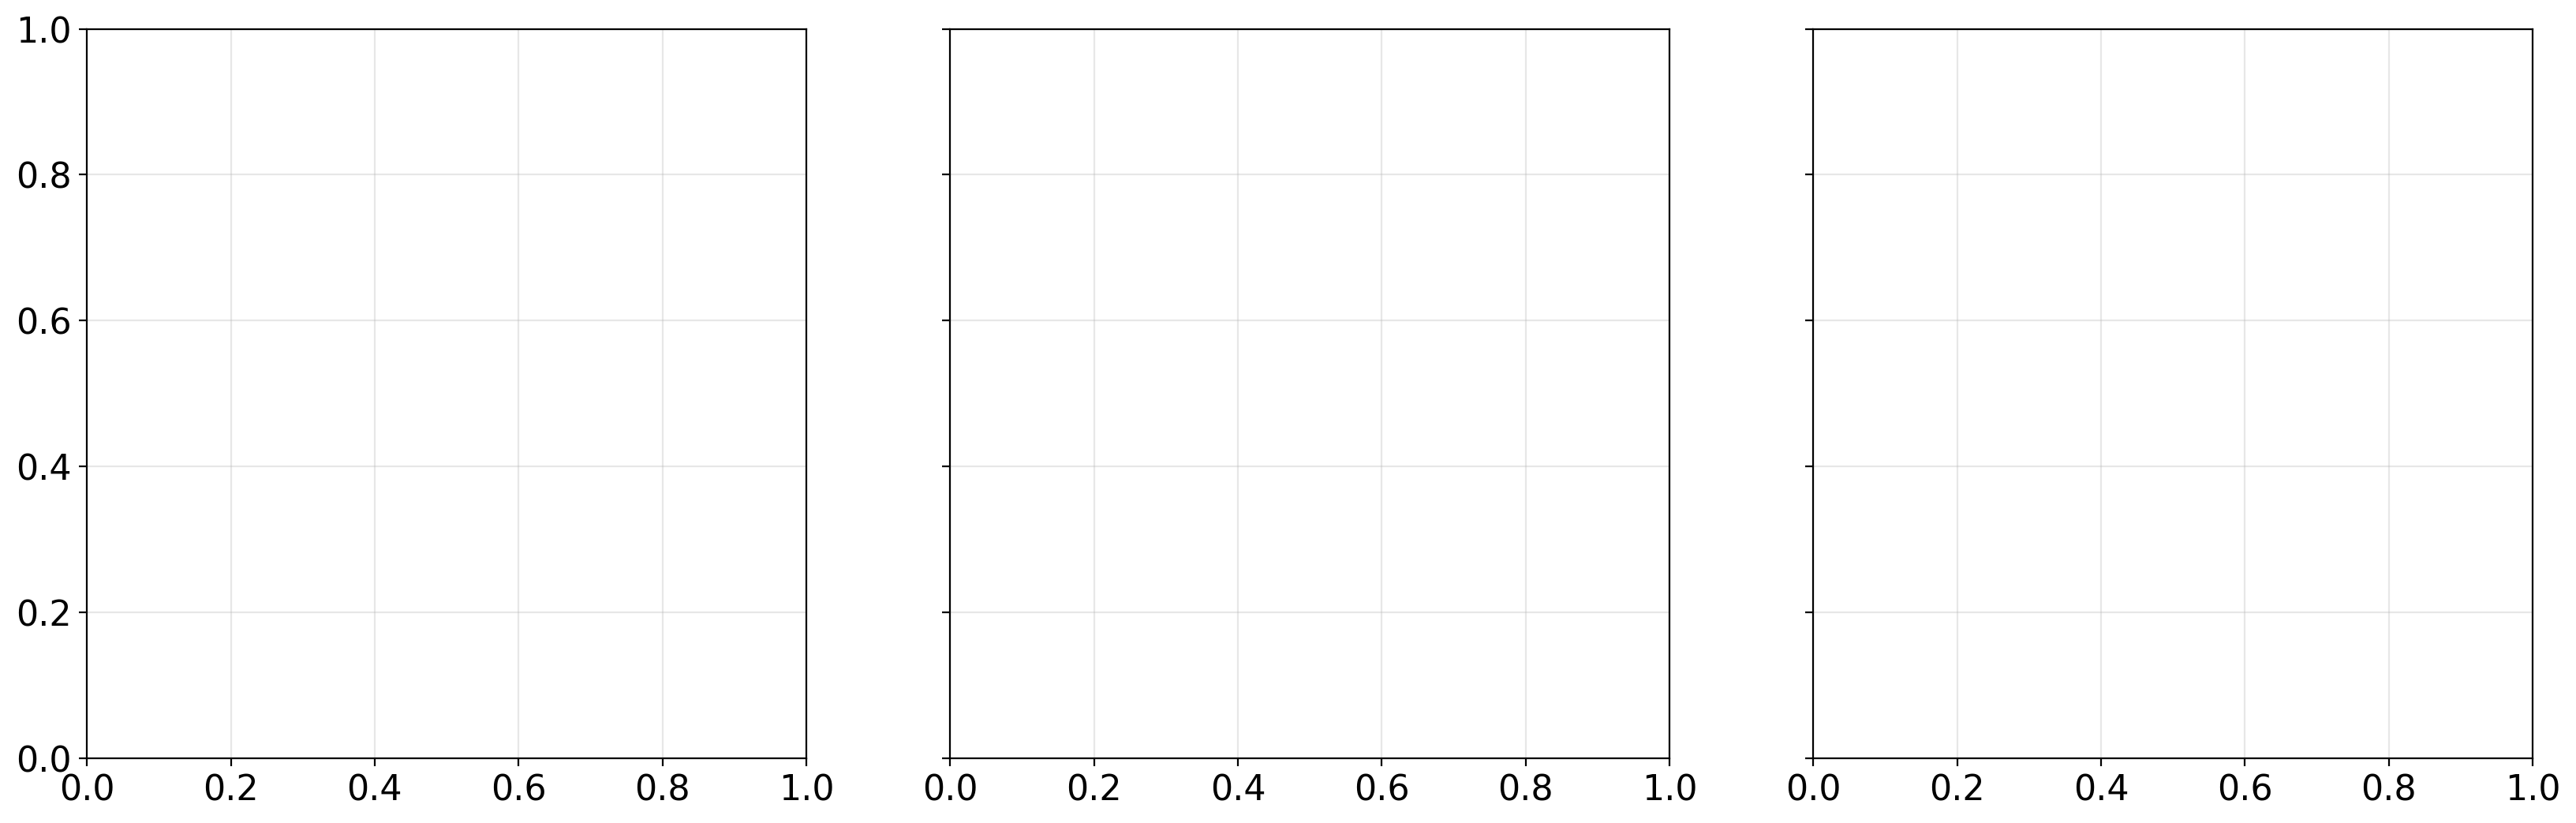

In [46]:
lmbd_str = f'{model.lmbd:.1e}'.replace('e+0', 'e').replace('e-0', 'e-')
filename = f'{graph}_lmbd-{lmbd_str}_n-{model.n}_d-{model.d}_m-{model.m}'
filename_fig = 'figs/vfl/' + filename + '.pdf'
filename_dump = 'dumps/vfl/' + filename + '.pkl'

#results = load_object(filename_dump)

#fig, ax = plt.subplots(1, 3, figsize=(14, 4), sharey=True)
fig, ax = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

for title in results.keys():
    output = results[title]
    x_vals = np.cumsum(output['grad_calls'])
    y_vals = output['x_err']
    if title == 'Main':
        title = 'Main algorithm'
    ax[0].plot(x_vals, y_vals, label=title)
ax[0].legend(loc='upper right')
ax[0].yaxis.set_tick_params(labelleft=True)
#ax[0].set_xlim(left=0, right=1_000)
#ax[0].set_ylim(bottom=1e-18, top=1e3)
ax[0].set_yscale('log')
ax[0].set_xlabel("Gradient calls")
ax[0].ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

for title in results.keys():
    output = results[title]
    x_vals = np.cumsum(output['mults_A'])
    y_vals = output['x_err']
    if title == 'Main':
        title = 'Main algorithm'
    ax[1].plot(x_vals, y_vals, label=title)
ax[1].legend(loc='upper right')
ax[1].yaxis.set_tick_params(labelleft=True)
#ax[1].set_xlim(left=0, right=140_000)
ax[1].set_yscale('log')
ax[1].set_xlabel("Multiplications by $\mathbf{A}$ and $\mathbf{A}^T$")
ax[1].ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

for title in results.keys():
    output = results[title]
    x_vals = np.cumsum(output['communications'])
    y_vals = output['x_err']
    if title == 'Main':
        title = 'Main algorithm'
    ax[2].plot(x_vals, y_vals, label=title)
ax[2].legend(loc='upper right')
ax[2].yaxis.set_tick_params(labelleft=True)
#ax[2].set_xlim(left=0, right=100_000)
ax[2].set_yscale('log')
ax[2].set_xlabel("Communications")
ax[2].ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

#plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
fig.text(0, 0.5, r"$\| x^k - x^* \|_2^2$", va='center', rotation='vertical')
graph_name = 'Ring' if graph == 'ring' else 'Erdős–Rényi'
#plt.suptitle(f"{graph_name}, $\lambda = {lmbd_str}$, $n = {model.n}$, $d_i = {model.d}$, $m = {model.m}$", fontsize=24)
plt.tight_layout()
plt.savefig(filename_fig, bbox_inches='tight')
#save_object(results, filename_dump)
plt.show()

## Labels are distributed between devices

$$ x_1 = \begin{pmatrix} w_1 \\ z_1 \end{pmatrix}, \quad x_2 = \begin{pmatrix} w_2 \\ z_2 \end{pmatrix}, \quad \ldots, \quad x_n = \begin{pmatrix} w_n \\ z_n \end{pmatrix} $$

$$ f_i(x_i) = f_i(w_i, z_i) = \frac{1}{2}\|z_i - l_i\|_2^2 + \lambda \|w_i\|_2^2, \quad i = 1, \ldots, n $$

$$ A_i = \begin{pmatrix} \mathbf{F}_i & \mathbf{C}_i \end{pmatrix}, \qquad \mathbf{C}_i = \begin{pmatrix} \mathbf{O}_{\mathrm{dim}(z_i)} \\ \vdots \\ -\mathbf{I}_{\mathrm{dim}(z_i)} \\ \vdots \\ \mathbf{O}_{\mathrm{dim}(z_i)} \end{pmatrix}, \quad i = 1, \ldots, n $$

In [ ]:
np.random.seed(307)

# mushrooms (8124, 112)
# a9a       (32561, 123)
# w8a       (49749, 300)
# synthetic (sample_size, sample_size // 100)
lmbd = 1e0
sample_size = 1000
NUM_STEPS = 100
n = 2
title = 'mushrooms' # a9a / w8a / synthetic
graph = 'erdos-renyi'
average_degree = 1

model = VFL(n, lmbd=lmbd, title=title, sample_size=sample_size, 
            graph=graph, edge_prob=average_degree/sample_size, gossip=False,
            labels_distribution=True) # !!!!

In [ ]:
titles = ['Tracking-ADMM', 'DPMM', 'APAPC', 'Main']
results = {title: {} for title in titles}

output = TrackingADMM(num_steps=NUM_STEPS, model=model)
results['Tracking-ADMM'] = output

output = DPMM(num_steps=NUM_STEPS, model=model)
results['DPMM'] = output

output = APAPC(num_steps=NUM_STEPS, model=model)
results['APAPC'] = output

output = Main(num_steps=NUM_STEPS, model=model)
results['Main'] = output

In [ ]:
lmbd_str = f'{model.lmbd:.1e}'.replace('e+0', 'e').replace('e-0', 'e-')
filename = f'{graph}_lmbd-{lmbd_str}_n-{model.n}_d-{model.d}_m-{model.m}'
filename_fig = 'figs/vfl/' + filename + 'labels-distributed' + '.pdf'
filename_dump = 'dumps/vfl/' + filename + 'labels-distributed' + '.pkl'

#results = load_object(filename_dump)

fig, ax = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for title in results.keys():
    output = results[title]
    x_vals = np.cumsum(output['grad_calls'])
    y_vals = output['x_err']
    ax[0].plot(x_vals, y_vals, label=title)
ax[0].yaxis.set_tick_params(labelleft=True)
ax[0].set_xlim(left=0, right=10_000)
ax[0].set_ylim(bottom=1e-17, top=1e3)
ax[0].set_yscale('log')
ax[0].set_xlabel("Gradient calls")
ax[0].ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

for title in results.keys():
    output = results[title]
    x_vals = np.cumsum(output['mults_A'])
    y_vals = output['x_err']
    ax[1].plot(x_vals, y_vals, label=title)
ax[1].yaxis.set_tick_params(labelleft=True)
ax[1].set_xlim(left=0, right=400_000)
ax[1].set_ylim(bottom=1e-17, top=1e3)
ax[1].set_yscale('log')
ax[1].set_xlabel("Multiplications by $\mathbf{A}$ and $\mathbf{A}^T$")
ax[1].ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

for title in results.keys():
    output = results[title]
    x_vals = np.cumsum(output['communications'])
    y_vals = output['x_err']
    ax[2].plot(x_vals, y_vals, label=title)
ax[2].yaxis.set_tick_params(labelleft=True)
ax[2].set_xlim(left=0, right=100_000)
ax[2].set_ylim(bottom=1e-17, top=1e3)
ax[2].set_yscale('log')
ax[2].set_xlabel("Communications")
ax[2].ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
fig.text(0, 0.5, r"$\| x^k - x^* \|_2^2$", va='center', rotation='vertical')
graph_name = 'Ring' if graph == 'ring' else 'Erdős–Rényi'
plt.suptitle(f"{graph_name}, $\lambda = {lmbd_str}$, $n = {model.n}$, $d_i = {model.d}$, $m = {model.m}$", fontsize=24)
plt.tight_layout()
plt.savefig(filename_fig, bbox_inches='tight')
save_object(results, filename_dump)
plt.show()